# Fully saturated TWFE の解釈

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices

figsize=(1.618*6, 1*6)

In [2]:
path = '../../data/processed/fully_saturated/homo.csv'
beta_df = pd.read_csv(path)
# path = '../../data/processed/fully_saturated/hetero.csv'
# hetero_beta_df = pd.read_csv(path)
path = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(path)
df = df.rename(columns={'island_names': '島名'})
path = '../../data/raw/yashiro_and_shodo.xlsx'
df_yashiro_shodo = pd.read_excel(path)


In [13]:
class FullySaturatedPlotter():
    def __init__(self, data=None, trace=None, beta_df=None):
        self.data = data
        self.trace = trace
        self.beta_df = beta_df

    def plot_treatment_effect(self, bridge_year, ax=None):
        beta_g = self.beta_df.query(f'bridge_year == {bridge_year}').sort_values('time_since_treatment')
        fig, ax = plt.subplots(figsize=figsize)
        sns.lineplot(data=beta_g, x='time_since_treatment', y='mean', color='black', marker='o', label='平均', ax=ax)
        ax.fill_between(
            x='time_since_treatment',
            y1='hdi_97.5%',
            y2='hdi_2.5%',
            data=beta_g,
            alpha=0.3,
            color='black',
            label='95%信用区間'
        )
        ax.axhline(0, color='black', ls=':')
        ax.axvline(0, color='black', ls=':')
        ax.set_title(f'介入: {bridge_year} 年')
        ax.set_xlabel('経過年数')
        ax.set_ylabel('係数')
        ax.legend()

    def plot_population(self, bridge_year, ax=None):
        df_g = self.data.query(f'bridge_year == {bridge_year}')
        print(df_g.island_ids.unique())
        fig, ax = plt.subplots(figsize=figsize)
        sns.lineplot(x='year', y='population', data=df_g, color='black', ax=ax)
        ax.axvline(0, color='black', ls=':')
        ax.set_title(f'介入: {bridge_year}')
        ax.set_xlabel('経過年数')
        ax.set_ylabel('人口')

    def plot_population_and_treatment_effect(self, bridge_year, fig_num=None):
        fig, ax = plt.subplots(2, 1, figsize=figsize)
        fig.suptitle(f'図{fig_num}: {bridge_year}年に開通した橋の介入効果', fontsize=16, y=0.93)
        # fig.subplots_adjust(hspace=0.4)
        # 人口変化率のプロット
        df_g = self.data.query(f'bridge_year == {bridge_year}')
        # num_obs = df_g.island_ids.nunique()
        sns.lineplot(
            x='year',
            y='pop_rate_of_change',
            data=df_g,
            color='black',
            marker='o',
            ax=ax[0],
            hue='島名',
            palette=['black'],
        )

        # 年平均のプロット
        year_df = pd.DataFrame()
        year_df['year_mean'] = self.data.groupby('year')['log_pop'].mean()
        min_year = df_g.year.min()
        year_df = year_df.query(f'year >= {min_year}')
        year_df['year_mean_diff'] = year_df.year_mean.diff()
        year_df.fillna(0, inplace=True)
        year_df['year_mean_cumsum'] = year_df['year_mean_diff'].cumsum()
        year_df['year_mean_change_rate'] = 100 * (np.exp(year_df['year_mean_cumsum']) - 1)
        sns.lineplot(data=year_df, x=year_df.index, y='year_mean_change_rate', ax=ax[0], color='black', marker='o', label='年平均', ls='--')
        # 装飾
        ax[0].axvline(bridge_year, color='black', ls=':', label='介入年')
        ax[0].set_title('')
        ax[0].set_ylabel('人口増加率 (%)')
        ax[0].set_xlabel('')
        ax[0].legend()

        # 係数のプロット
        beta_g = self.beta_df.query(f'bridge_year == {bridge_year}').sort_values('time_since_treatment')
        sns.lineplot(
            data=beta_g,
            x='time_since_treatment',
            y='mean',
            color='black',
            marker='o',
            # label='事後期待値',
            ax=ax[1]
        )
        ax[1].fill_between(
            x='time_since_treatment',
            y1='hdi_97.5%',
            y2='hdi_2.5%',
            data=beta_g,
            alpha=0.3,
            color='black',
            # label='95%信用区間'
        )
        ax[1].axhline(0, color='black', ls=':')
        ax[1].axvline(0, color='black', ls=':')
        ax[1].set_title('')
        ax[1].set_xlabel('経過年数')
        ax[1].set_ylabel('係数')
        # ax[1].legend()

        filepath = f'../../docs/figures/fully_saturated_twfe/{bridge_year}.png'
        fig.savefig(filepath, bbox_inches='tight')

In [14]:
beta_homo = FullySaturatedPlotter(data=df, beta_df=beta_df)

/tmp/ipykernel_18995/2434286542.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df['year_mean_diff'] = year_df.year_mean.diff()
/tmp/ipykernel_18995/2434286542.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_df.fillna(0, inplace=True)
/tmp/ipykernel_18995/2434286542.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

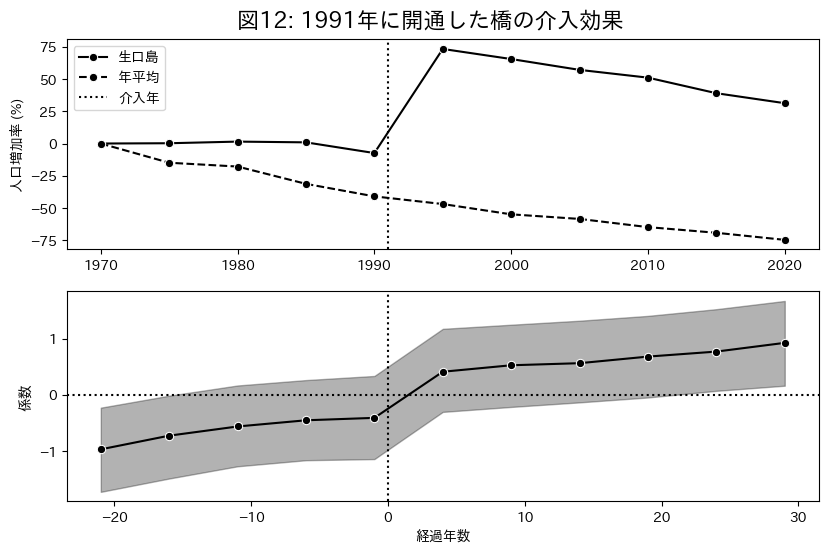

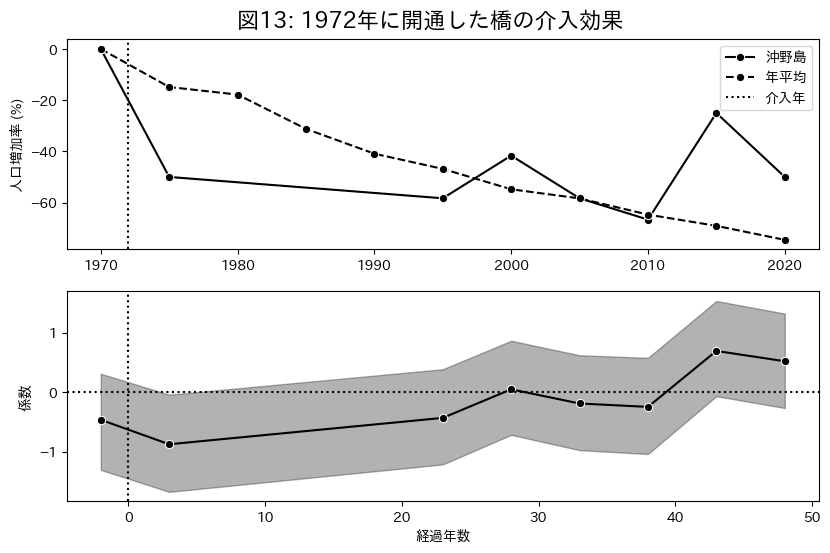

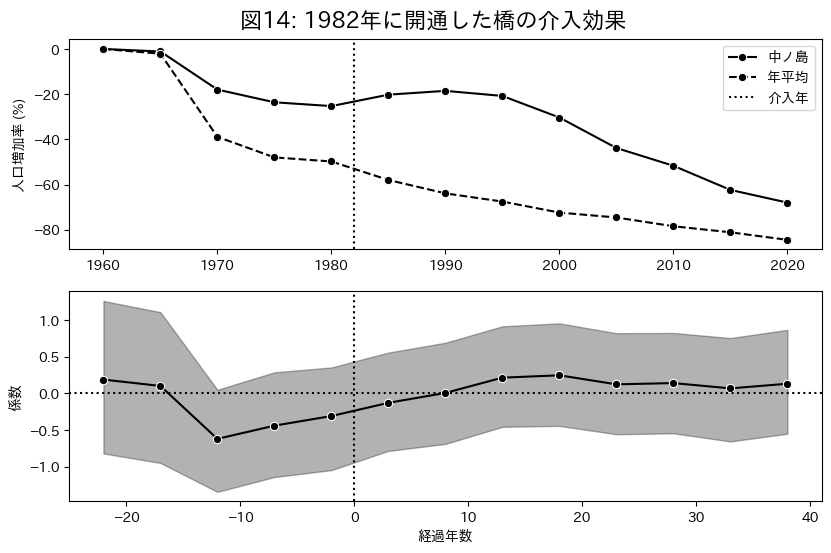

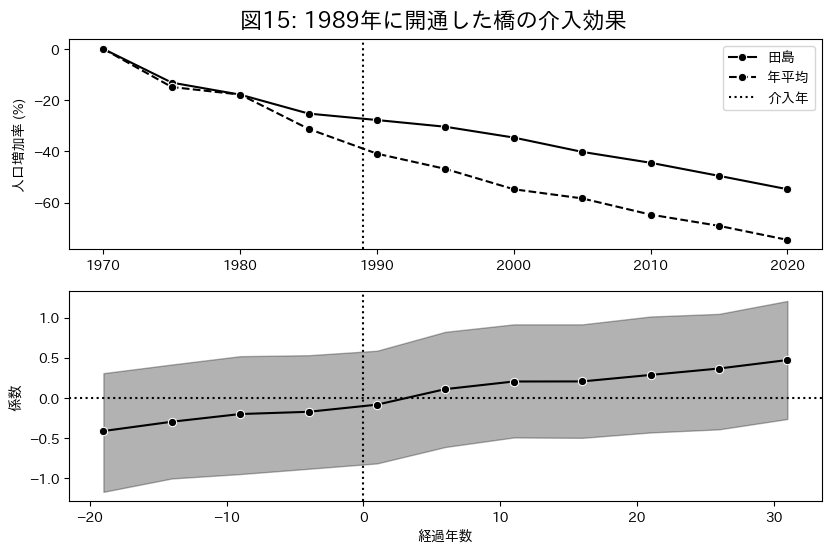

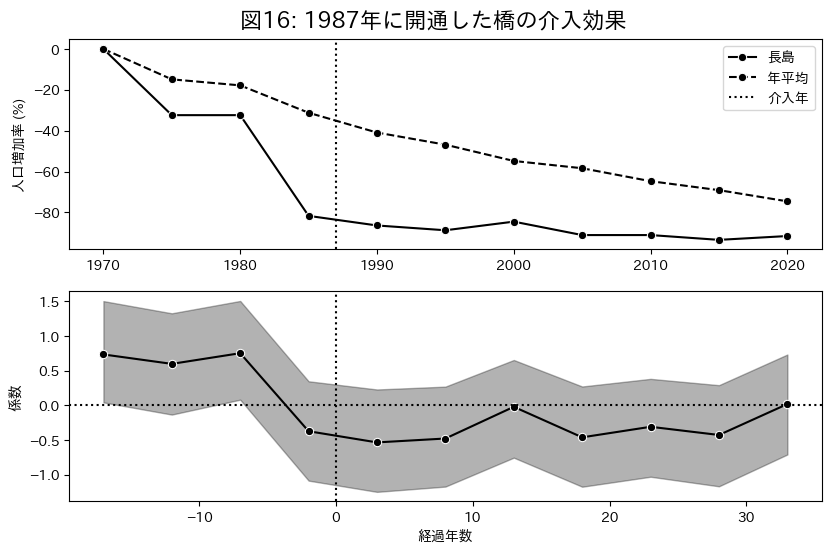

In [15]:
bridge_year_list = [1991, 1972, 1982, 1989, 1987]
fig_num_list = [12, 13, 14, 15, 16]
for i in range(len(bridge_year_list)):
    beta_homo.plot_population_and_treatment_effect(bridge_year=bridge_year_list[i], fig_num=fig_num_list[i])

In [118]:
bridge_year_list_same_as_year_mean = [1975, 1992, 1995, 2000, 2008]
for bridge_year in bridge_year_list_same_as_year_mean:
    beta_homo.plot_population_and_treatment_effect(bridge_year=bridge_year)

NameError: name 'beta_homo' is not defined

## 屋代島 (周防大島)

In [ ]:
df_yashiro_shodo = df_yashiro_shodo.dropna(subset=['population'])
df_yashiro_shodo['log_pop'] = np.log(df_yashiro_shodo['population'])
df_yashiro_shodo['log_pop_diff'] = df_yashiro_shodo.groupby('island_ids')['log_pop'].diff()
df_yashiro_shodo['log_pop_diff'] = df_yashiro_shodo.groupby('island_ids')['log_pop_diff'].fillna(0)
df_yashiro_shodo['log_pop_diff_rate'] = df_yashiro_shodo.groupby('island_ids')['log_pop_diff'].cumsum()
df_yashiro_shodo['pop_rate_of_change'] = 100 * (np.exp(df_yashiro_shodo['log_pop_diff_rate']) - 1)

/tmp/ipykernel_86691/2568875776.py:4: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df_yashiro_shodo['log_pop_diff'] = df_yashiro_shodo.groupby('island_ids')['log_pop_diff'].fillna(0)


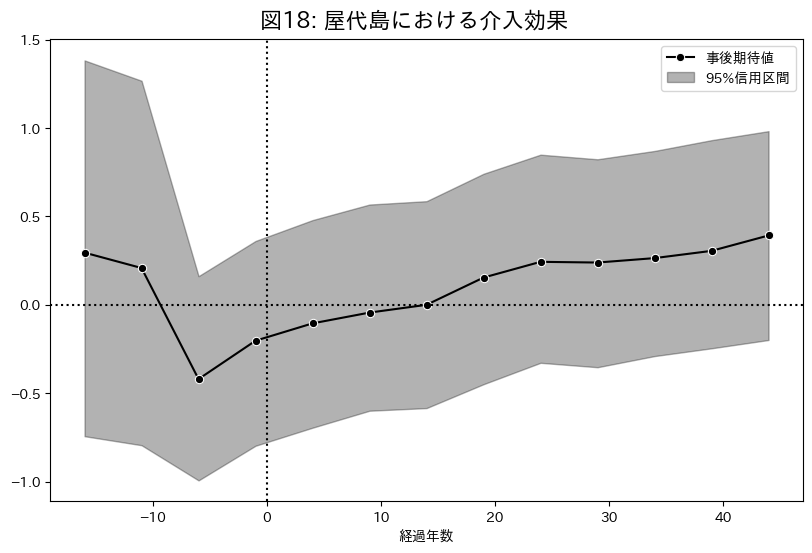

In [18]:
island_names = '屋代島'
bridge_year = 1976

fig, ax = plt.subplots(figsize=figsize)
fig.suptitle(f'図18: 屋代島における介入効果', fontsize=16, y=0.93)
# 係数のプロット
beta_g = beta_df.query(f'bridge_year == {bridge_year}').sort_values('time_since_treatment')
sns.lineplot(
    data=beta_g,
    x='time_since_treatment',
    y='mean',
    color='black',
    marker='o',
    label='事後期待値',
    ax=ax
)
ax.fill_between(
    x='time_since_treatment',
    y1='hdi_97.5%',
    y2='hdi_2.5%',
    data=beta_g,
    alpha=0.3,
    color='black',
    label='95%信用区間'
)
ax.axhline(0, color='black', ls=':')
ax.axvline(0, color='black', ls=':')
ax.set_xlabel('経過年数')
ax.set_ylabel('')
ax.legend()

filepath = f'../../docs/figures/fully_saturated_twfe/yashiro.png'
fig.savefig(filepath, bbox_inches='tight')

In [5]:
df_yashiro_shodo

,island_names,year,island_ids,region_codes,region_names,prefecture_codes,population,treatment_group,treatment_group_mainland,bridge_year,after_treatment,connect_mainland_year,after_treatment_mainland,prefecture_names,area_km2,distance_m,log_pop,log_pop_diff,log_pop_diff_rate,pop_rate_of_change
0,屋代島,1970,125,35302,（旧）大島町,35,35760,1,1,1976,0,1976,0,山口県,128.48,950,10.484585,0.000000,0.000000,0.000000
1,屋代島,1975,125,35302,（旧）大島町,35,32870,1,1,1976,0,1976,0,山口県,128.48,950,10.400316,-0.084270,-0.084270,-8.081655
2,屋代島,1980,125,35302,（旧）大島町,35,30810,1,1,1976,1,1976,1,山口県,128.48,950,10.335595,-0.064721,-0.148991,-13.842282
3,屋代島,1985,125,35302,（旧）大島町,35,29057,1,1,1976,1,1976,1,山口県,128.48,950,10.277015,-0.058580,-0.207571,-18.744407
4,屋代島,1990,125,35302,（旧）大島町,35,26503,1,1,1976,1,1976,1,山口県,128.48,950,10.185013,-0.092001,-0.299572,-25.886465
5,屋代島,1995,125,35302,（旧）大島町,35,24039,1,1,1976,1,1976,1,山口県,128.48,950,10.087433,-0.097580,-0.397152,-32.776846
6,屋代島,2000,125,35302,（旧）大島町,35,21796,1,1,1976,1,1976,1,山口県,128.48,950,9.989482,-0.097951,-0.495103,-39.049217
7,屋代島,2005,125,35305,周防大島町,35,20813,1,1,1976,1,1976,1,山口県,128.48,950,9.943333,-0.046149,-0.541252,-41.798098
8,屋代島,2010,125,35305,周防大島町,35,18589,1,1,1976,1,1976,1,山口県,128.48,950,9.830325,-0.113008,-0.654260,-48.017338
9,屋代島,2015,125,35305,周防大島町,35,16766,1,1,1976,1,1976,1,山口県,128.48,950,9.727108,-0.103217,-0.757477,-53.115213


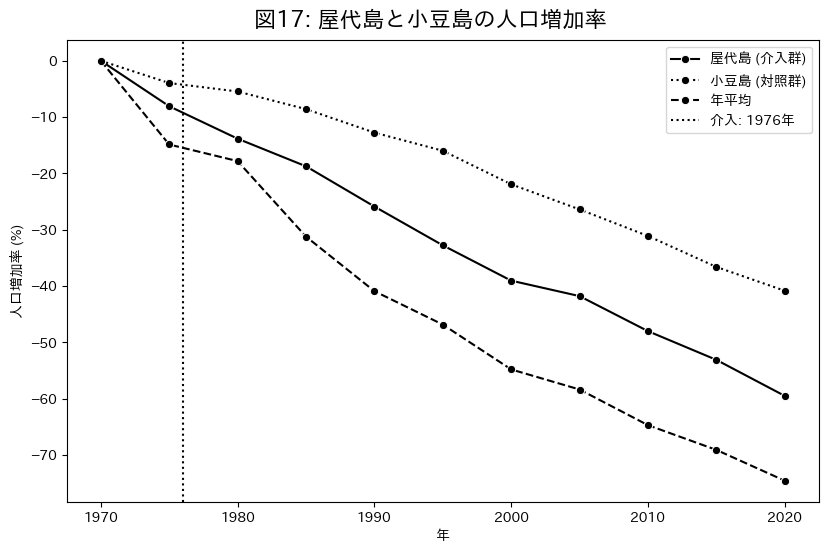

In [19]:
fig, ax = plt.subplots(figsize=(1.618*6, 1*6))
fig.suptitle('図17: 屋代島と小豆島の人口増加率', fontsize=16, y=0.93)
# 人口増加率のプロット
sns.lineplot(
    x='year',
    y='pop_rate_of_change',
    data=df_yashiro_shodo.query('island_names == "屋代島"'),
    color='black',
    marker='o',
    ax=ax,
    label='屋代島 (介入群)'
)
sns.lineplot(
    x='year',
    y='pop_rate_of_change',
    data=df_yashiro_shodo.query('island_names == "小豆島"'),
    color='black',
    marker='o',
    ax=ax,
    label='小豆島 (対照群)',
    ls=':'
)
# 年平均のプロット
year_df = pd.DataFrame()
year_df['year_mean'] = df.groupby('year')['log_pop'].mean()
min_year = df_yashiro_shodo.year.min()
year_df = year_df.query(f'year >= {min_year}')
year_df['year_mean_diff'] = year_df.year_mean.diff()
year_df.fillna(0, inplace=True)
year_df['year_mean_cumsum'] = year_df['year_mean_diff'].cumsum()
year_df['year_mean_change_rate'] = 100 * (np.exp(year_df['year_mean_cumsum']) - 1)
sns.lineplot(data=year_df, x=year_df.index, y='year_mean_change_rate', ax=ax, color='black', marker='o', label='年平均', ls='--')
ax.axvline(bridge_year, color='black', ls=':', label=f'介入: {bridge_year}年')
ax.set_ylabel('人口増加率 (%)')
ax.set_xlabel('年')
ax.legend()
plt.savefig('../../docs/figures/fully_saturated_twfe/yashiro_shodo.png', bbox_inches='tight')

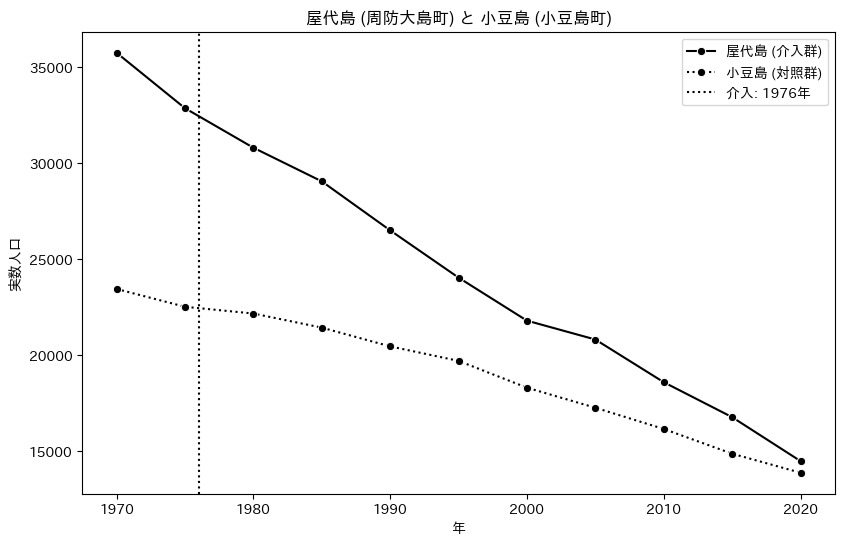

In [7]:
bridge_year = 1976

fig, ax = plt.subplots(figsize=(1.618*6, 1*6))
# 人口変化率のプロット
sns.lineplot(
    x='year',
    y='population',
    data=df_yashiro_shodo.query('island_names == "屋代島"'),
    color='black',
    marker='o',
    ax=ax,
    label='屋代島 (介入群)'
)
sns.lineplot(
    x='year',
    y='population',
    data=df_yashiro_shodo.query('island_names == "小豆島"'),
    color='black',
    marker='o',
    ax=ax,
    label='小豆島 (対照群)',
    ls=':'
)
ax.axvline(bridge_year, color='black', ls=':', label=f'介入: {bridge_year}年')
ax.set_title('屋代島 (周防大島町) と 小豆島 (小豆島町)')
ax.set_ylabel('実数人口')
ax.set_xlabel('年')
ax.legend()
plt.savefig('../../docs/figures/fully_saturated_twfe/yashiro_shodo_real.png', bbox_inches='tight')

In [8]:
year_df

,year_mean,year_mean_diff,year_mean_cumsum,year_mean_change_rate
year,,,,
1970,6.370601,0.000000,0.000000,0.000000
1975,6.209552,-0.161049,-0.161049,-14.874962
1980,6.174318,-0.035234,-0.196283,-17.822059
1985,5.996276,-0.178042,-0.374325,-31.224652
1990,5.844400,-0.151876,-0.526201,-40.915449
1995,5.738550,-0.105850,-0.632051,-46.849933
2000,5.576233,-0.162317,-0.794368,-54.813333
2005,5.494012,-0.082221,-0.876589,-58.379989
2010,5.328979,-0.165033,-1.041622,-64.711826


## なぜ効果が島によって異なるのか

In [ ]:
beta_df['time_since_treatment'].unique()

array([-10,  -5,   0,   5,  10,  15,  25,  30,  35,  40,  45,  50,  -2,
         3,  23,  28,  33,  38,  43,  48,  -3,   2,   7,  12,  17,  22,
        27,  32,  37,  42,  47,  20, -16, -11,  -6,  -1,   4,   9,  14,
        19,  24,  29,  34,  39,  44,  -9,  -4,   1,   6,  11,  16,  21,
        26,  31,  36,  41, -22, -17, -12,  -7,   8,  13,  18, -13,  -8,
       -18, -19, -14, -21, -25, -20, -15, -26, -29, -24, -30, -34, -33,
       -28, -23, -41, -36, -31, -45, -40, -35, -46])

<Axes: xlabel='bridge_year', ylabel='mean'>

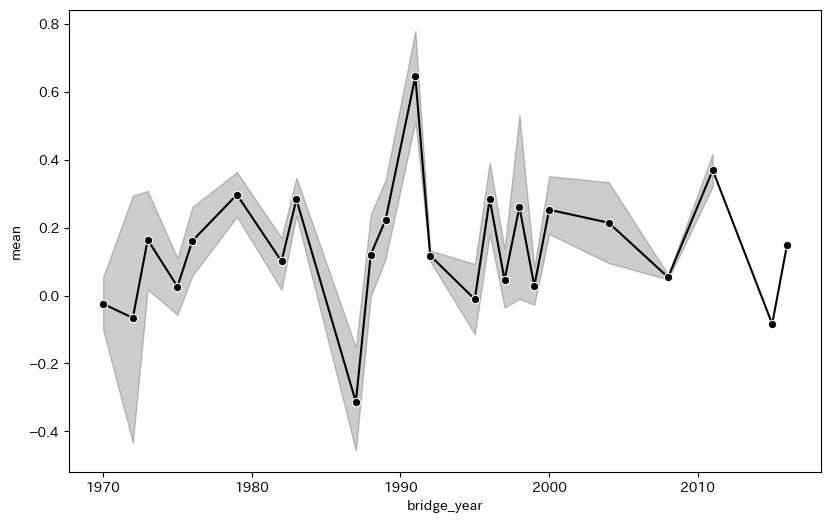

In [36]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x='bridge_year', y='mean', data=beta_df.query('time_since_treatment > 0'), color='black', marker='o')